### Notebook for analysing nf pipeline output

#### Sequencing batch 8

### Sequencing information 
 - Analysis no.: A003
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext FS and NEBNext
 - Seq Date: 30-04-2021
 - Number of samples:76

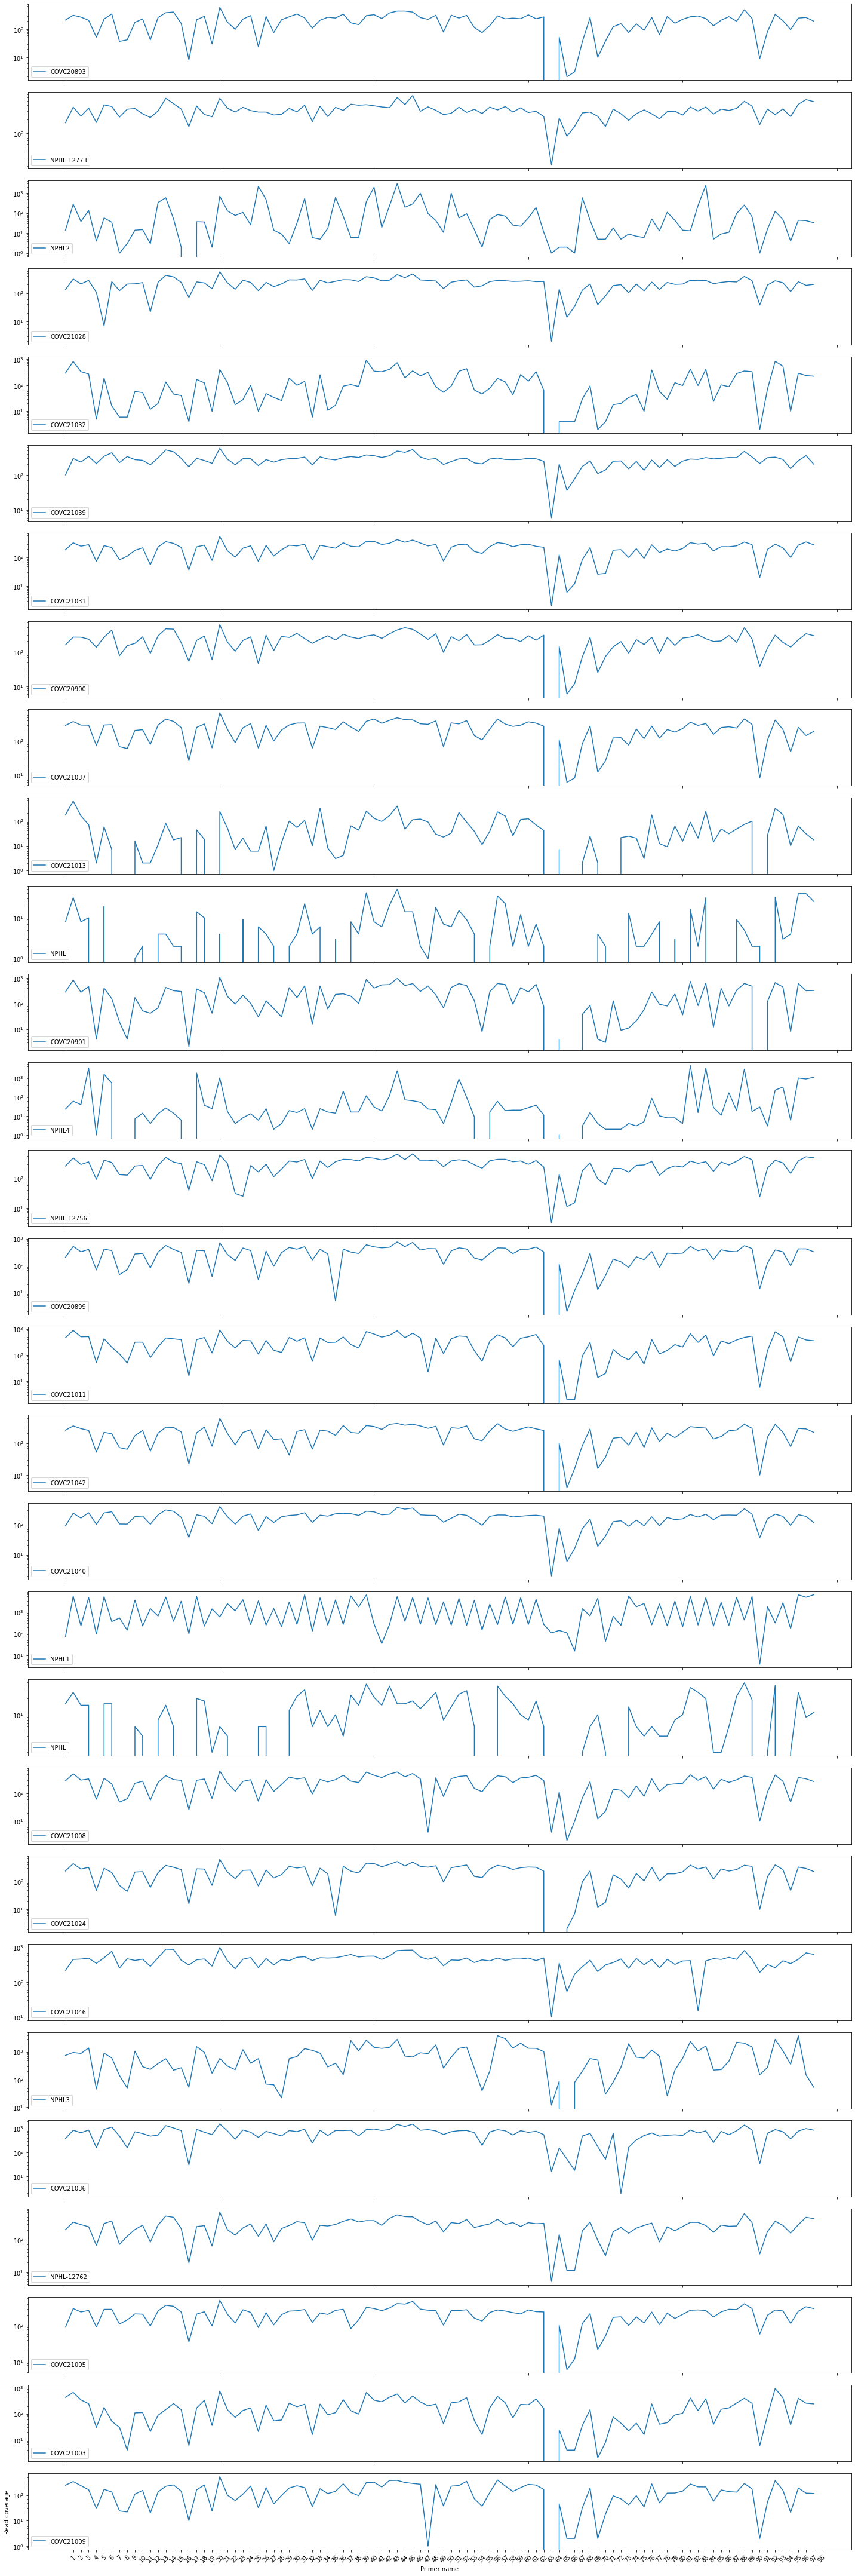

In [1]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.amplicon.regions.coverage.tsv'
base_dir = '/home/douso/Kibet/2021-04-30_run6_NPHL_COVC/dpt'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1
fig, axs = plt.subplots(a, b, figsize=(20,60)) 

xtick = np.arange(1, 99)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    sample_df = pd.read_table(f'{base_dir}/{file}')
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='lower left')
plt.xlabel('Primer name')
plt.ylabel('Read coverage')
plt.xticks(xtick, rotation=45)
plt.tight_layout()
plt.show()
#fig.savesample_df2fig('avg_kit_coverage2.png')


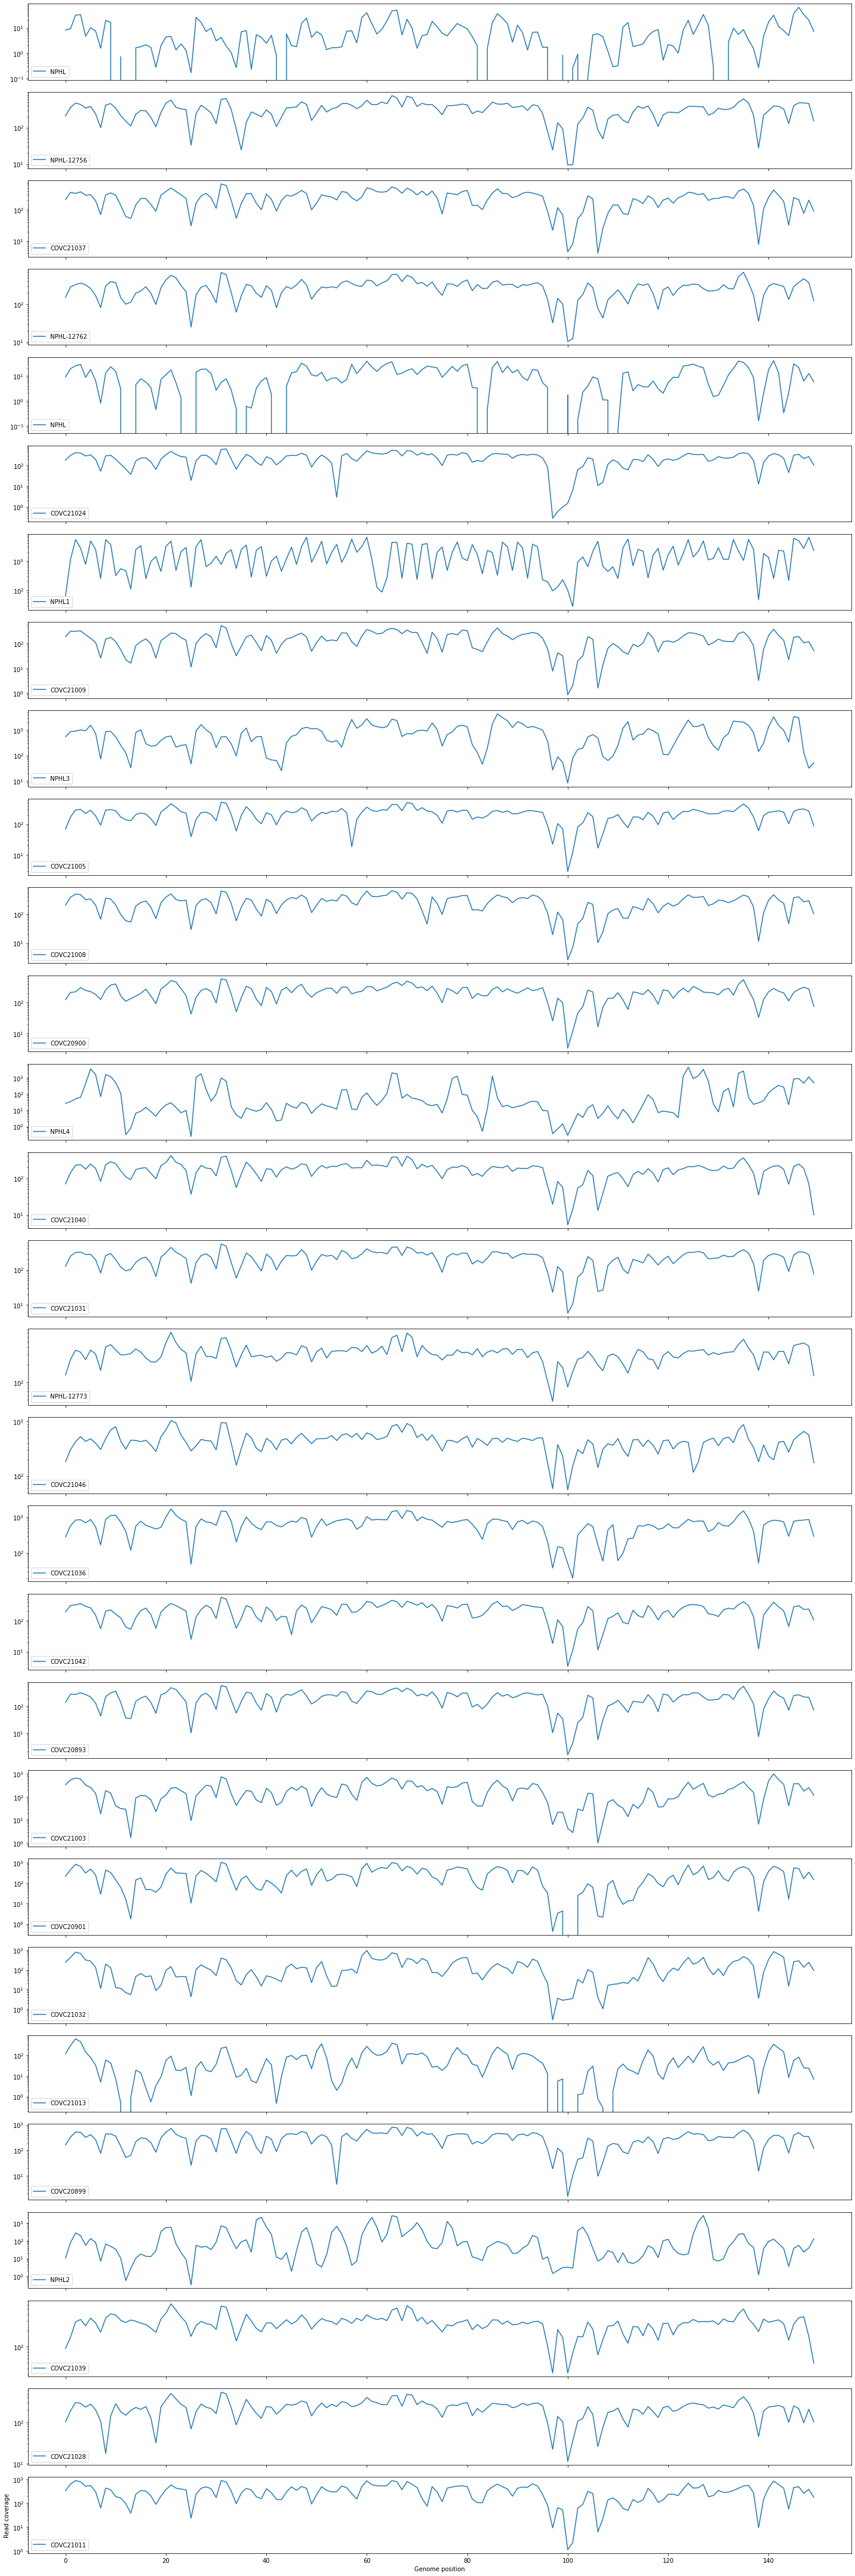

In [2]:
# plot read depths-GK
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt

suffix = '.genome.regions.coverage.tsv'
base_dir = '/home/douso/Kibet/2021-04-30_run6_NPHL_COVC/dpt'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fig, axs = plt.subplots(a, b, figsize=(20, 60))

xtick = range(0, 30000, 500)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    try:
        df1 = pd.read_table(f'{base_dir}/{file}')
        df1['coverage'].plot(logy=True, ax=axs[c], sharex=True)
        axs[c].legend([sample_name], loc='lower left')
        text = file.split('_')[1]
        plt.ylabel('Read coverage')
    except TypeError:
            print(f'no numeric data to plot for {file}')
    finally: pass
plt.xlabel('Genome position')
# plt.xticks(xtick, rotation=45)
plt.tight_layout()
plt.show()
#fig.savefig('avg_kit_coverage.png')

## Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import glob

In [4]:
base_dir = '/home/douso/Kibet/2021-04-30_run6_NPHL_COVC'
batch = 'seq8'
# dpt_dir = # ivar, samtools-depth output files
# nxt_dir = # nextclade .tsv output file
# png_dir = # pangolin .tsv output file
# var_dir = # snpEff ouput
# rmd_dir = # raw metadata - moh .xlsx spread sheet
#dpt var nxt png

## Analysis of batch 3 and 4 
### Sequencing information 
 - Analysis no.: NF-002 (batch 8)
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext (FS and non-FS)
 - Seq Date: MiSeq (30-04-2021)
 - Number of samples: 29
 - Sample summ: COVCs and NPHL
 - VC pipeline: nextflow-viralcon

## Functions

In [5]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [6]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [7]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [8]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.merge(df_nxt_cln, how='outer', left_on='sample_name', right_on='seqName')
                 .drop('seqName', axis=1))

In [9]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.merge(df_varNxt, how='left', left_on='Sequence_name', right_on='sample_name')
            .drop('sample_name', axis=1))

In [10]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.merge(df_cts_cln, left_on='Sample_No', right_on='Sample_Name')
            .drop('Sample_Name', axis=1))


In [11]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.merge(df_rmdCts, how='left', left_on='Sequence_name', right_on='Sample_No')
                 .drop('Sample_No', axis=1))

In [12]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('_')[0]))
    return df_fnl

### Variants data

In [13]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(f'{base_dir}/var/k-per-gene_variant_anns.tsv')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: x.split('_')[0]))

In [14]:
df_var_fnl.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC20901,14,"E102Q, T265I, F924F, S2535L, K3353R, L4715L",NaN,"D614G, L1200L, Q1201K,",Q57H,NaN,NaN,NaN,NaN,NaN,NaN,"A14T, V62L",P13S,NaN,NaN,N25N
1,COVC21024,16,"F924F, Q1009R, V3595V, L4715L, C5557F, I5747T,...",NaN,"D614G, P681H","W69S, A99S",NaN,NaN,"T9T, L57L",NaN,NaN,NaN,S69P,"T205I, L400L",NaN,NaN,NaN
2,COVC21031,16,"F924F, Q1759H, P2046L, T3255I, N3801N, L3899L,...",NaN,"D614G, R683R, I882V","R134L, C148C",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NPHL,5,"A1708D, F3100F, S5665I",NaN,D1118H,Q57H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COVC21032,24,"S216S, F924F, Q1009R, Y1425H, A1708D, V3595V, ...",NaN,"G261D, D614G, P681H, T716I, F1103L, I1114I,","Q57H, W69S",NaN,NaN,"T9T, L57L","D61H, D61V, D61D",NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Nextclade data

In [15]:
# import Nextclade clade data
df_nxt = pd.read_table(f'{base_dir}/nxt/NPHL_COVC_con.tsv')

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: x.split('_')[0]))
df_nxt_fnl = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)

In [16]:
df_nxt_fnl.head()

,seqName,clade,coverage
0,COVC20893,20A,93.3
1,COVC20899,20A,93.3
2,COVC20900,20C,95.7
3,COVC20901,20C,83.3
4,COVC21003,20C,87.4


### Pangolin data v.2.4.2 (25-04-2021)

In [68]:
# import Pangolin lineage data
df_png = pd.read_csv(f'{base_dir}/png/NPHL_COVC_con.pangolin.csv', header=0)
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Date_range', 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_cln1 = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: x.split('_')[0]))
df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months)))

In [70]:
df_png_fnl.head()

,Sequence_name,Lineage,Date_range,Most_common_countries
0,COVC20893,B.1,"Jan-24, Apr-13","USA, UK, Spain"
1,COVC20899,B.1.530,"Oct-28, Jan-25","Kenya, Denmark, Netherlands"
2,COVC20900,B.1,"Jan-24, Apr-13","USA, UK, Spain"
3,COVC20901,B.1,"Jan-24, Apr-13","USA, UK, Spain"
4,COVC21003,B.1,"Jan-24, Apr-13","USA, UK, Spain"


# Metadata

In [71]:
# import raw metadata file
import pandas as pd
mbase_dir = '/home/douso/Documents/RunSheets'
df_rmd = pd.read_excel(f'{mbase_dir}/Sequencing_metadata_merged_raw.xlsx')

In [72]:
df_rmd.head()

,Testing Lab,Case ID,Type of Case,Sample No,Sample name,ID,Age,Age Unit,Gender,Phone No,...,Quarantine facility,Have symptoms,Date of Onset of symptoms,Symptoms shown,Sample Type,Date of Sample Collection,Date Sample Received in the lab,Result,Lab confirmation date,Unnamed: 30
0,ILRI,Nil,Intial,COVC1849,Parsitao Richard Silange,Nil,35.0,Years,M,Nil,...,Loitoktok sub-county hospital,No,NaN,NaN,NP Swab,44004,44006,Positive,24/06/2020,NaN
1,ILRI,CH008,Intial,COVC4504,Margaret Njoki Wainaina,21161498,41.0,Years,F,722691418,...,NaN,No,NaN,NaN,NP Swab,44032,44035,Positive,23/07/2020,NaN
2,ILRI,NYR 1248,Intial,COVC5267,Joseph Ngunjiri Kiciara,not_indicated,57.0,Years,M,720812784,...,Mount Kenya Hospital,Yes,not_indicated,"Dyspnea, Abnormal x-ray findings, shortness of...",NP Swab,28/7/2020,31/7/2020,Positive,31/7/2020,NaN
3,ILRI,047/TD133,Repeat,COVC7585,BENSON CHEGE,8029997,52.0,Years,M,721949628,...,NaN,No,NaN,NaN,NP Swab,44056,44057,Positive,44057,NaN
4,ILRI,COVE561,Initial,COVC22135_1,NaN,NaN,NaN,Years,F,NaN,...,NaN,No,NaN,NaN,NP Swab,44160,44160,Positive,44161,NaN


In [73]:
cols = ['Sample_No', 'Age', 'Age_Unit', 'Gender', 'Occupation'
         , 'Nationality', 'County_of_Residence', 'Has_travel_History'
         , 'Travel_from', 'Quarantine_facility', 'Have_symptoms'
         , 'Date_of_Onset_of_symptoms', 'Symptoms_shown', 'Sample_Type'
         , 'Date_of_Sample_Collection','Date_Sample_Received_in_the_lab'
        , 'Result', 'Lab_confirmation_date']
df_rmd_cln = get_cols(tidy_header(df_rmd), cols)

In [74]:
df_rmd_cln.head()

,Sample_No,Age,Age_Unit,Gender,Occupation,Nationality,County_of_Residence,Has_travel_History,Travel_from,Quarantine_facility,Have_symptoms,Date_of_Onset_of_symptoms,Symptoms_shown,Sample_Type,Date_of_Sample_Collection,Date_Sample_Received_in_the_lab,Result,Lab_confirmation_date
0,COVC1849,35.0,Years,M,Prisoner,Kenya,Kajiado,No,NaN,Loitoktok sub-county hospital,No,NaN,NaN,NP Swab,44004,44006,Positive,24/06/2020
1,COVC4504,41.0,Years,F,Healthcare worker,Kenya,Kajiado,No,NaN,NaN,No,NaN,NaN,NP Swab,44032,44035,Positive,23/07/2020
2,COVC5267,57.0,Years,M,Teacher,Kenya,Nyeri,No,NaN,Mount Kenya Hospital,Yes,not_indicated,"Dyspnea, Abnormal x-ray findings, shortness of...",NP Swab,28/7/2020,31/7/2020,Positive,31/7/2020
3,COVC7585,52.0,Years,M,Truck Driver,Kenya,Uasin Gishu,No,NaN,NaN,No,NaN,NaN,NP Swab,44056,44057,Positive,44057
4,COVC22135_1,NaN,Years,F,NaN,Kenya,Nairobi,No,NaN,NaN,No,NaN,NaN,NP Swab,44160,44160,Positive,44161


### Ct data

In [75]:
# import Ct data from sheet2 of the metadata file
df_cts = pd.read_excel(f'{mbase_dir}/Cts/cov-allCts-merged.xlsx')

In [76]:
df_cts.head()

,Sample_Name,Average_Ct
0,COVC1849,16.282
1,COVC4504,17.410
2,COVC5267,20.300
3,COVC7585,23.940
4,COVC22135_1,25.550


In [77]:
# cols = ['Sample_Name', 'Average_Ct']
# df_cts_cln = get_cols(tidy_header(df_cts), cols)
# df_cts_fnl = df_cts_cln.assign(Sequence_name = df_cts_cln['Sequence_name'].apply(lambda x: x.split('_')[0]))

In [78]:
# df_cts_cln.head()

### Combining data

#### Merge Variants and Nextclade data

In [79]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [80]:
df_varNxt.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC20901,14,"E102Q, T265I, F924F, S2535L, K3353R, L4715L",NaN,"D614G, L1200L, Q1201K,",Q57H,NaN,NaN,NaN,NaN,NaN,NaN,"A14T, V62L",P13S,NaN,NaN,N25N,20C,83.3
1,COVC21024,16,"F924F, Q1009R, V3595V, L4715L, C5557F, I5747T,...",NaN,"D614G, P681H","W69S, A99S",NaN,NaN,"T9T, L57L",NaN,NaN,NaN,S69P,"T205I, L400L",NaN,NaN,NaN,20A,91.3
2,COVC21031,16,"F924F, Q1759H, P2046L, T3255I, N3801N, L3899L,...",NaN,"D614G, R683R, I882V","R134L, C148C",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20A,95.4
3,NPHL,5,"A1708D, F3100F, S5665I",NaN,D1118H,Q57H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19A,23.7
4,NPHL,5,"A1708D, F3100F, S5665I",NaN,D1118H,Q57H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20B,17.7


#### Merge pango and var-nextclade data

In [81]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [82]:
df_pngVxt.head()

,Sequence_name,Lineage,Date_range,Most_common_countries,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC20893,B.1,"Jan-24, Apr-13","USA, UK, Spain",10,"K680N, F924F, V4677I, D4697G, L4715L, R5947M",NaN,"D614G, P728P",L83F,NaN,...,NaN,NaN,NaN,NaN,S206F,NaN,NaN,NaN,20A,93.3
1,COVC20899,B.1.530,"Oct-28, Jan-25","Kenya, Denmark, Netherlands",15,"F924F, E940D, Q1009R, R3480K, V3595V, L4577F, ...",NaN,"D614G, P681H",A99S,NaN,...,NaN,NaN,NaN,S69P,"T205I, L400L",NaN,NaN,NaN,20A,93.3
2,COVC20900,B.1,"Jan-24, Apr-13","USA, UK, Spain",20,"E102Q, T265I, F924F, D953Y, K3353R, A3755A, N4...",NaN,"D614G, L1200L, Q1201K","Q57H, Y113Y",NaN,...,NaN,NaN,NaN,"A14T, A51V, V62L","P13S, R195K, P207T",NaN,NaN,N25N,20C,95.7
3,COVC20901,B.1,"Jan-24, Apr-13","USA, UK, Spain",14,"E102Q, T265I, F924F, S2535L, K3353R, L4715L",NaN,"D614G, L1200L, Q1201K,",Q57H,NaN,...,NaN,NaN,NaN,"A14T, V62L",P13S,NaN,NaN,N25N,20C,83.3
4,COVC21003,B.1,"Jan-24, Apr-13","USA, UK, Spain",15,"L61L, E102Q, T265I, F924F, T2910I, K3353R, L4715L",NaN,"V70V, D80Y, S375S, D614G",Q57H,NaN,...,NaN,NaN,NaN,NaN,"P13S, R195K, P207T",NaN,NaN,NaN,20C,87.4


#### Merge the metadata and Cts data

In [83]:
# merge metadata with cts data
df_rmdCts = merge_rmdCts(df_rmd_cln, df_cts)

In [84]:
df_rmdCts#.head()

,Sample_No,Age,Age_Unit,Gender,Occupation,Nationality,County_of_Residence,Has_travel_History,Travel_from,Quarantine_facility,Have_symptoms,Date_of_Onset_of_symptoms,Symptoms_shown,Sample_Type,Date_of_Sample_Collection,Date_Sample_Received_in_the_lab,Result,Lab_confirmation_date,Average_Ct
0,COVC1849,35.0,Years,M,Prisoner,Kenya,Kajiado,No,NaN,Loitoktok sub-county hospital,No,NaN,NaN,NP Swab,44004,44006,Positive,24/06/2020,16.282000
1,COVC4504,41.0,Years,F,Healthcare worker,Kenya,Kajiado,No,NaN,NaN,No,NaN,NaN,NP Swab,44032,44035,Positive,23/07/2020,17.410000
2,COVC5267,57.0,Years,M,Teacher,Kenya,Nyeri,No,NaN,Mount Kenya Hospital,Yes,not_indicated,"Dyspnea, Abnormal x-ray findings, shortness of...",NP Swab,28/7/2020,31/7/2020,Positive,31/7/2020,20.300000
3,COVC7585,52.0,Years,M,Truck Driver,Kenya,Uasin Gishu,No,NaN,NaN,No,NaN,NaN,NP Swab,44056,44057,Positive,44057,23.940000
4,COVC22135_1,NaN,Years,F,NaN,Kenya,Nairobi,No,NaN,NaN,No,NaN,NaN,NP Swab,44160,44160,Positive,44161,25.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,COVC23750,NaN,Years,M,NaN,Kenya,Nairobi,No,NaN,NaN,No,NaN,NaN,NP Swab,44286,44286,Positive,44287,37.780729
379,COVC23752,NaN,Years,M,NaN,Kenya,Nairobi,No,NaN,NaN,No,NaN,NaN,NP Swab,44287,44287,Positive,44287,24.377522
380,COVC23752,NaN,Years,M,NaN,Kenya,Nairobi,No,NaN,NaN,No,NaN,NaN,NP Swab,44287,44287,Positive,44287,24.400000
381,COVC23753,NaN,Years,M,NaN,Kenya,Nairobi,No,NaN,NaN,No,NaN,NaN,NP Swab,44287,44287,Positive,44287,36.753473


#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [85]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [86]:
df_vnpPmd.head()

,Sequence_name,Lineage,Date_range,Most_common_countries,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,...,Quarantine_facility,Have_symptoms,Date_of_Onset_of_symptoms,Symptoms_shown,Sample_Type,Date_of_Sample_Collection,Date_Sample_Received_in_the_lab,Result,Lab_confirmation_date,Average_Ct
0,COVC20893,B.1,"Jan-24, Apr-13","USA, UK, Spain",10,"K680N, F924F, V4677I, D4697G, L4715L, R5947M",NaN,"D614G, P728P",L83F,NaN,...,NaN,Yes,44124,CO;DIB,NP Swab,44145,44147,Positive,44148,18.847032
1,COVC20899,B.1.530,"Oct-28, Jan-25","Kenya, Denmark, Netherlands",15,"F924F, E940D, Q1009R, R3480K, V3595V, L4577F, ...",NaN,"D614G, P681H",A99S,NaN,...,NaN,No,NaN,NaN,NP Swab,44146,44147,Positive,44148,19.630886
2,COVC20900,B.1,"Jan-24, Apr-13","USA, UK, Spain",20,"E102Q, T265I, F924F, D953Y, K3353R, A3755A, N4...",NaN,"D614G, L1200L, Q1201K","Q57H, Y113Y",NaN,...,NaN,No,NaN,NaN,NP Swab,44146,44147,Positive,44148,16.692623
3,COVC20901,B.1,"Jan-24, Apr-13","USA, UK, Spain",14,"E102Q, T265I, F924F, S2535L, K3353R, L4715L",NaN,"D614G, L1200L, Q1201K,",Q57H,NaN,...,NaN,Yes,44141,CO;DIB;P-C,NP Swab,44146,44147,Positive,44148,26.062973
4,COVC21003,B.1,"Jan-24, Apr-13","USA, UK, Spain",15,"L61L, E102Q, T265I, F924F, T2910I, K3353R, L4715L",NaN,"V70V, D80Y, S375S, D614G",Q57H,NaN,...,NaN,Yes,NaN,CO,NP Swab,44145,44148,Positive,44151,30.080167


#### QC whether all samples sequenced had metadata

In [87]:
codes_fnl = set(df_vnpPmd['Sequence_name'])
codes_metadata = set(df_rmdCts['Sample_No'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
{'NPHL-12762', 'NPHL4', 'NPHL-12756', 'NPHL1', 'NPHL2', 'NPHL-12773'}


These sample codes were in the sequencing data but not on the metadata. `NPHLs` didn't have metadata
 - NPHL3
 - NPHL4
 - NPHL2
 - NPHL-12773
 - NPHL1
 - NPHL-12756

#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [88]:
df_vnpPmd.columns

Index(['Sequence_name', 'Lineage', 'Date_range', 'Most_common_countries',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage', 'Age', 'Age_Unit', 'Gender', 'Occupation', 'Nationality',
       'County_of_Residence', 'Has_travel_History', 'Travel_from',
       'Quarantine_facility', 'Have_symptoms', 'Date_of_Onset_of_symptoms',
       'Symptoms_shown', 'Sample_Type', 'Date_of_Sample_Collection',
       'Date_Sample_Received_in_the_lab', 'Result', 'Lab_confirmation_date',
       'Average_Ct'],
      dtype='object')

In [89]:
header = ['Sequence_name', 'Lineage', 'Most_common_countries', 'Date_range'
          , 'num_vars', 'S', 'clade','coverage', 'Age', 'Age_Unit', 'Gender'
          , 'Occupation', 'Nationality', 'County_of_Residence', 'Has_travel_History'
          , 'Travel_from', 'Quarantine_facility', 'Have_symptoms'
          , 'Date_of_Onset_of_symptoms', 'Symptoms_shown', 'Sample_Type'
          , 'Date_of_Sample_Collection', 'Date_Sample_Received_in_the_lab'
          , 'Result', 'Lab_confirmation_date', 'Average_Ct', 'ORF1ab', 'ORF1a'
          , 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N'
          , 'ORF9a', 'ORF9b', 'ORF10']

In [90]:
header2 = ['Sequence_name', 'Age', 'Age_Unit', 'Gender'
          , 'Occupation', 'Nationality', 'County_of_Residence', 'Has_travel_History'
          , 'Travel_from', 'Quarantine_facility', 'Have_symptoms'
          , 'Date_of_Onset_of_symptoms', 'Symptoms_shown', 'Sample_Type'
          , 'Date_of_Sample_Collection', 'Date_Sample_Received_in_the_lab'
          , 'Result', 'Lab_confirmation_date', 'Average_Ct', 'Lineage'
          , 'Most_common_countries', 'Date_range', 'clade','coverage'
          , 'num_vars', 'S',  'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E'
          , 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [91]:
header3 = ['Sequence_name', 'Age', 'Age_Unit', 'Gender'
          , 'Occupation', 'Nationality', 'County_of_Residence', 'Has_travel_History'
          , 'Travel_from', 'Quarantine_facility', 'Have_symptoms'
          , 'Date_of_Onset_of_symptoms', 'Symptoms_shown', 'Sample_Type'
          , 'Date_of_Sample_Collection', 'Date_Sample_Received_in_the_lab'
          , 'Result', 'Lab_confirmation_date', 'Average_Ct']

In [118]:
df_vnpPmd_fnl = df_vnpPmd[header3]
# df_vnpPmd_fnl.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-M003.xlsx'
#                      , index=False, na_rep='N/A', float_format='%.1f')

In [119]:
df_vnpPmd_fnl = df_vnpPmd[header2]
# df_vnpPmd_fnl.to_excel('/home/douso/SarsGenomics/Processed/metadata-seq-MS003.xlsx'
#                      , index=False, na_rep='NA', float_format='%.1f')
df_vnpPmd_fnl.head()

,Sequence_name,Age,Age_Unit,Gender,Occupation,Nationality,County_of_Residence,Has_travel_History,Travel_from,Quarantine_facility,...,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC20893,42.0,Years,F,Business,Kenya,Kiambu,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,S206F,NaN,NaN,NaN
1,COVC20899,57.0,Years,F,Medical Representative,Kenya,Kiambu,No,NaN,NaN,...,NaN,T9T,NaN,NaN,NaN,S69P,"T205I, L400L",NaN,NaN,NaN
2,COVC20900,34.0,Years,F,Medical Representative,Kenya,Kiambu,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"A14T, A51V, V62L","P13S, R195K, P207T",NaN,NaN,N25N
3,COVC20901,78.0,Years,F,Farmer,Kenya,Kiambu,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"A14T, V62L",P13S,NaN,NaN,N25N
4,COVC21003,50.0,Years,F,NaN,Kenya,Kiambu,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"P13S, R195K, P207T",NaN,NaN,NaN


### Variants of Concern or under investigation
 - N501Y (B.1.1.7): UK variant
 - N501Y, E484K, *K417N (B.1.351): SA variant
 - N501Y, E484K (P.1): Brazilian variant
 - P681R, E484Q, L452R (B.1.617): *Indian variant

In [94]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [95]:
df_moc.head()

,Sample_ID,Mut_of_Concern_(S),All_Mutations_(S)
0,NPHL-12773,"A570D, N501Y","Y145del, N501Y, A570D, D614G, P681H, T716I, S982A"
1,NPHL1,"A570D, N501Y","Y145del, N501Y, A570D, D614G, P681H, T716I, S982A"
2,NPHL-12762,"A570D, N501Y","Y145del, N501Y, A570D, D614G, P681H, T716I, S9..."
3,NPHL-12756,"A570D, N501Y","Y145del, N501Y, A570D, D614G, P681H, T716I, S9..."
4,NPHL2,A570D,"A570D, D614G"


### Subsample brief data

In [96]:
df_vnpPmd.columns

Index(['Sequence_name', 'Lineage', 'Date_range', 'Most_common_countries',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage', 'Age', 'Age_Unit', 'Gender', 'Occupation', 'Nationality',
       'County_of_Residence', 'Has_travel_History', 'Travel_from',
       'Quarantine_facility', 'Have_symptoms', 'Date_of_Onset_of_symptoms',
       'Symptoms_shown', 'Sample_Type', 'Date_of_Sample_Collection',
       'Date_Sample_Received_in_the_lab', 'Result', 'Lab_confirmation_date',
       'Average_Ct'],
      dtype='object')

In [97]:
#reorder columns and shrink data
cols = ['Sequence_name', 'coverage', 'Date_Sample_Received_in_the_lab', 'Lineage', 'clade', 'County_of_Residence'
        , 'Gender', 'Nationality']

### Filter reporting coverage

In [98]:
df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['coverage'] >= 80]

In [99]:
df_brief#.head()

,Sequence_name,coverage,Date_Sample_Received_in_the_lab,Lineage,clade,County_of_Residence,Gender,Nationality
0,COVC20893,93.3,44147,B.1,20A,Kiambu,F,Kenya
1,COVC20899,93.3,44147,B.1.530,20A,Kiambu,F,Kenya
2,COVC20900,95.7,44147,B.1,20C,Kiambu,F,Kenya
3,COVC20901,83.3,44147,B.1,20C,Kiambu,F,Kenya
4,COVC21003,87.4,44148,B.1,20C,Kiambu,F,Kenya
5,COVC21005,95.8,44148,B.1,20C,Kiambu,F,Kenya
6,COVC21008,93.4,44148,B.1,20C,Kiambu,F,Kenya
7,COVC21009,89.1,44148,B.1,20C,Kiambu,M,Kenya
8,COVC21011,92.8,44148,B.1,20C,Kiambu,F,Kenya
10,COVC21024,91.3,44148,B.1.530,20A,Kiambu,F,Kenya


#### Merge df_brief with df_moc

In [100]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='Sequence_name', right_on='Sample_ID'))
df_brfMoc_fnl = (df_brfMoc.fillna('NA')
                 .loc[df_brfMoc['Sequence_name'] != 'Undetermined']# removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1))

In [101]:
df_brfMoc_fnl['Date_Sample_Received_in_the_lab'].value_counts()

44148    14
NA        4
44147     4
Name: Date_Sample_Received_in_the_lab, dtype: int64

In [102]:
df_brfMoc_fnl

,Sequence_name,coverage,Date_Sample_Received_in_the_lab,Lineage,clade,County_of_Residence,Gender,Nationality,Mut_of_Concern_(S)
0,COVC20893,93.3,44147,B.1,20A,Kiambu,F,Kenya,NA
1,COVC20899,93.3,44147,B.1.530,20A,Kiambu,F,Kenya,NA
2,COVC20900,95.7,44147,B.1,20C,Kiambu,F,Kenya,NA
3,COVC20901,83.3,44147,B.1,20C,Kiambu,F,Kenya,NA
4,COVC21003,87.4,44148,B.1,20C,Kiambu,F,Kenya,NA
5,COVC21005,95.8,44148,B.1,20C,Kiambu,F,Kenya,NA
6,COVC21008,93.4,44148,B.1,20C,Kiambu,F,Kenya,NA
7,COVC21009,89.1,44148,B.1,20C,Kiambu,M,Kenya,NA
8,COVC21011,92.8,44148,B.1,20C,Kiambu,F,Kenya,NA
9,COVC21024,91.3,44148,B.1.530,20A,Kiambu,F,Kenya,NA


### Policy brief report

In [103]:
#df_report = df_brfMoc_fnl.drop(['Sequence_name'], axis=1)

In [104]:
df_brfMoc_fnl.columns

Index(['Sequence_name', 'coverage', 'Date_Sample_Received_in_the_lab',
       'Lineage', 'clade', 'County_of_Residence', 'Gender', 'Nationality',
       'Mut_of_Concern_(S)'],
      dtype='object')

In [105]:
df_brfMoc_fnl.head()

,Sequence_name,coverage,Date_Sample_Received_in_the_lab,Lineage,clade,County_of_Residence,Gender,Nationality,Mut_of_Concern_(S)
0,COVC20893,93.3,44147,B.1,20A,Kiambu,F,Kenya,NA
1,COVC20899,93.3,44147,B.1.530,20A,Kiambu,F,Kenya,NA
2,COVC20900,95.7,44147,B.1,20C,Kiambu,F,Kenya,NA
3,COVC20901,83.3,44147,B.1,20C,Kiambu,F,Kenya,NA
4,COVC21003,87.4,44148,B.1,20C,Kiambu,F,Kenya,NA


#### Rename report columns

In [106]:
cols = ['Sequence Name', 'coverage','Date Received (dd-mm-yyyy)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'Sample County of Origin', 'Gender', 'Patient Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols

In [107]:
df_dates = pd.read_csv('/home/douso/Documents/TrendData/cov-dates.csv')

In [108]:
df_dates.head()

,SAMPLE_NAME,DATE_OF_SAMPLE_COLLECTION,DATE_SAMPLE_RECEIVED_IN_THE_LAB,LAB_CONFIRMATION_DATE
0,COVC7585,NaN,NaN,NaN
1,COVC22135,25-11-2020,25-11-2020,26-11-2020
2,COVC11310,28-09-2020,02-10-2020,03-10-2020
3,COVC11351,30-09-2020,02-10-2020,03-10-2020
4,COVC13064,05-10-2020,08-10-2020,09-10-2020


In [109]:
df_rptDts = df_brfMoc_fnl.merge(df_dates.set_index('SAMPLE_NAME'), how='left', left_on='Sequence Name', right_index=True)

In [110]:
df_rptDts#.head()

,Sequence Name,coverage,Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,Sample County of Origin,Gender,Patient Country of Origin,MoC-S-Protein,DATE_OF_SAMPLE_COLLECTION,DATE_SAMPLE_RECEIVED_IN_THE_LAB,LAB_CONFIRMATION_DATE
0,COVC20893,93.3,44147,B.1,20A,Kiambu,F,Kenya,NA,10-11-2020,12-11-2020,13-11-2020
1,COVC20899,93.3,44147,B.1.530,20A,Kiambu,F,Kenya,NA,11-11-2020,12-11-2020,13-11-2020
2,COVC20900,95.7,44147,B.1,20C,Kiambu,F,Kenya,NA,11-11-2020,12-11-2020,13-11-2020
3,COVC20901,83.3,44147,B.1,20C,Kiambu,F,Kenya,NA,11-11-2020,12-11-2020,13-11-2020
4,COVC21003,87.4,44148,B.1,20C,Kiambu,F,Kenya,NA,10-11-2020,13-11-2020,16-11-2020
5,COVC21005,95.8,44148,B.1,20C,Kiambu,F,Kenya,NA,10-11-2020,13-11-2020,16-11-2020
6,COVC21008,93.4,44148,B.1,20C,Kiambu,F,Kenya,NA,10-11-2020,13-11-2020,16-11-2020
7,COVC21009,89.1,44148,B.1,20C,Kiambu,M,Kenya,NA,10-11-2020,13-11-2020,16-11-2020
8,COVC21011,92.8,44148,B.1,20C,Kiambu,F,Kenya,NA,10-11-2020,13-11-2020,16-11-2020
9,COVC21024,91.3,44148,B.1.530,20A,Kiambu,F,Kenya,NA,10-11-2020,13-11-2020,16-11-2020


In [111]:
df_brfMoc_fnl['Date Received (dd-mm-yyyy)'] = df_rptDts['DATE_OF_SAMPLE_COLLECTION']

In [112]:
df_report_fnl = df_brfMoc_fnl.sort_values('Date Received (dd-mm-yyyy)')

In [113]:
# df_report_fnl.fillna('N/A').to_excel('/home/douso/SarsGenomics/Processed/policy-brief-T003.xlsx'
#                      , index=False, na_rep='N/A', float_format='%.1f')

In [114]:
(df_report_fnl['Sample County of Origin']
 .value_counts())

Kiambu      17
NA           4
Nairobi      1
Name: Sample County of Origin, dtype: int64

In [ ]:
clr_code = {'B.1.1.7': ('orange', '#FFA500'),
            'B.1.525': ('green', '#008000'), 
            'B.1.351': ('blue', '#0000FF'),
            'B.1.549': ('brown', '#A52A2A'),
            'A.23.1': ('gray', '#808080'),
            'B.1.596.1': ('magenta', '#FF00FF'),
            'B.1': ('cyan', '#00FFFF'),
            'B.1.530': ('red', '#FF0000'),
            'A.23': ('lime', '#00FF00'),
            'B.1.143': ('olive', '#808000'),
            'B.1.1.171': ('teal', '#008080'),
            'B.1.343': ('indigo', '#4B0082'),
            'B.1.388': ('sienna', '#A0522D')
            'TBA1': ('sienna', '#A0522D'),
            'TBA2': ('chocolate', '#D2691E'),
            'TBA3': ('chocolate', '#D2691E'),
            'TBA3': ('rosybrown', '#BC8F8F'),
            'TBA4': ('wheat', '#F5DEB3'),
            'TBA5': ('slategray', '#708090'),
            'TBA6': ('palevioletred', '#DB7093'),
            'TBA7': ('mediumpurple', '#9370DB'),
            'TBA8': ('tan', '#D2B48C'),
            'TBA9': ('aquamarine', '#7FFFD4')}

clr_lin = {'B.1.1.7': '#FFA500', 'B.1.525': '#008000', 'B.1.351': '#0000FF'
            , 'B.1.549': '#A52A2A', 'A.23.1': '#808080', 'B.1.596.1': '#FF00FF',
       'B.1': '#00FFFF', 'B.1.530': '#FF0000', 'A.23': '#00FF00', 'B.1.143': '#808000', 
       'B.1.1.171': '#008080', 'B.1.343': '#4B0082', 'B.1.388': '#A0522D'}

In [115]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

In [116]:
df_report_fnl.head()

,Sequence Name,coverage,Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,Sample County of Origin,Gender,Patient Country of Origin,MoC-S-Protein
0,COVC20893,93.3,10-11-2020,B.1,20A,Kiambu,F,Kenya,NA
11,COVC21031,95.4,10-11-2020,B.1.549,20A,Kiambu,F,Kenya,NA
10,COVC21028,95.8,10-11-2020,B.1,20C,Kiambu,F,Kenya,NA
9,COVC21024,91.3,10-11-2020,B.1.530,20A,Kiambu,F,Kenya,NA
7,COVC21009,89.1,10-11-2020,B.1,20C,Kiambu,M,Kenya,NA


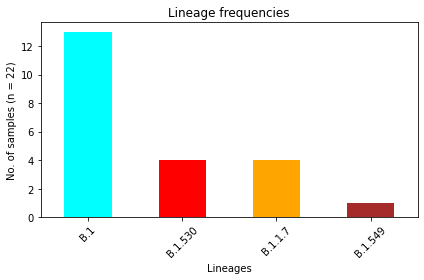

In [120]:
# plot lineage frequencies
colors = ['#00FFFF', '#FF0000', '#FFA500', '#A52A2A']
n = df_report_fnl['Pango Lineage Annotation'].count()
fig, ax = plt.subplots()
(df_report_fnl['Pango Lineage Annotation']
 .value_counts()
 .plot(kind='bar', ax=ax, color=colors))
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.xticks(rotation=45)
plt.ylabel(f'No. of samples (n = {n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P003.png', dpi=300.0)
plt.show()

In [ ]:
clr_code = {'B.1.1.7': ('orange', '#FFA500'),
            'B.1.525': ('green', '#008000'), 
            'B.1.351': ('blue', '#0000FF'),
            'B.1.549': ('brown', '#A52A2A'),
            'A.23.1': ('gray', '#808080'),
            'B.1.596.1': ('magenta', '#FF00FF'),
            'B.1': ('cyan', '#00FFFF'),
            'B.1.530': ('red', '#FF0000'),
            'A.23': ('lime', '#00FF00'),
            'B.1.143': ('olive', '#808000'),
            'B.1.1.171': ('teal', '#008080'),
            'B.1.343': ('indigo', '#4B0082'),
            'B.1.388': ('sienna', '#A0522D')
            'TBA1': ('sienna', '#A0522D'),
            'TBA2': ('chocolate', '#D2691E'),
            'TBA3': ('chocolate', '#D2691E'),
            'TBA3': ('rosybrown', '#BC8F8F'),
            'TBA4': ('wheat', '#F5DEB3'),
            'TBA5': ('slategray', '#708090'),
            'TBA6': ('palevioletred', '#DB7093'),
            'TBA7': ('mediumpurple', '#9370DB'),
            'TBA8': ('tan', '#D2B48C'),
            'TBA9': ('aquamarine', '#7FFFD4')}

clr_lin = {'B.1.1.7': '#FFA500', 'B.1.525': '#008000', 'B.1.351': '#0000FF'
            , 'B.1.549': '#A52A2A', 'A.23.1': '#808080', 'B.1.596.1': '#FF00FF',
       'B.1': '#00FFFF', 'B.1.530': '#FF0000', 'A.23': '#00FF00', 'B.1.143': '#808000', 
       'B.1.1.171': '#008080', 'B.1.343': '#4B0082', 'B.1.388': '#A0522D'}

### Analysis of the B.1.530 lineage samples that were clustering differently

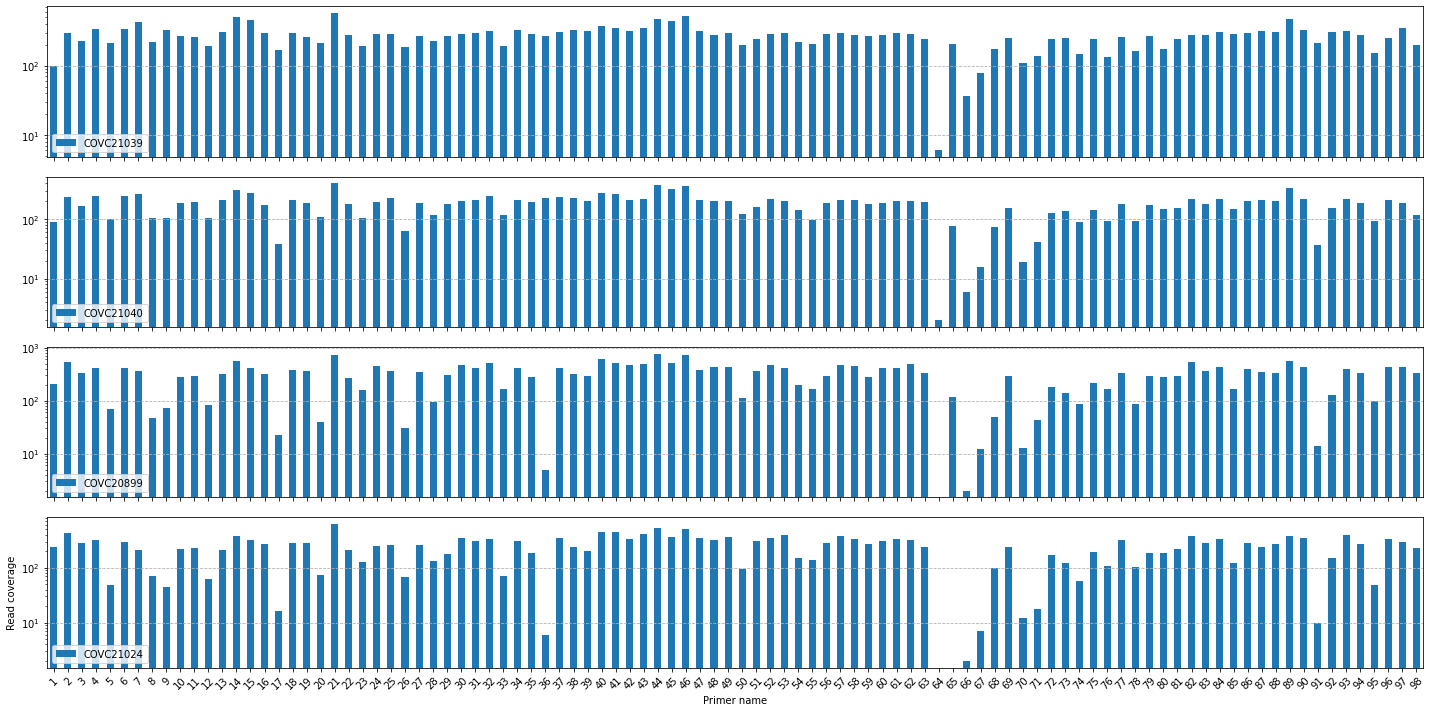

In [220]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.amplicon.regions.coverage.tsv'
base_dir = '/home/douso/Kibet/2021-04-30_run6_NPHL_COVC/dpt/b1.530'
files = ['COVC21039_S17.trim.mkD.amplicon.regions.coverage.tsv',
 'COVC21040_S18.trim.mkD.amplicon.regions.coverage.tsv',
 'COVC20899_S2.trim.mkD.amplicon.regions.coverage.tsv',
 'COVC21024_S11.trim.mkD.amplicon.regions.coverage.tsv']
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1
fig, axs = plt.subplots(a, b, figsize=(20,10)) 

xtick = np.arange(0, 98)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    sample_df = pd.read_table(f'{base_dir}/{file}')
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot.bar(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='lower left')
    axs[c].grid(axis='y', ls='--')
plt.xlabel('Primer name')
plt.ylabel('Read coverage')
plt.xticks(xtick, labels= range(1,99), rotation=45)
plt.tight_layout()
plt.show()
# fig.savefig(f'{base_dir}/bar-primer-b1.530.pdf')


In [202]:
import re, os

aa_code = {
    "Ala": "A", "Cys": "C", "Asp": "D", "Glu": "E", "Phe": "F",
    "Gly": "G", "His": "H", "Ile": "I", "Lys": "K", "Leu": "L",
    "Met": "M", "Asn": "N", "Pro": "P", "Gln": "Q", "Arg": "R",
    "Ser": "S", "Thr": "T", "Val": "V", "Trp": "W", "Tyr": "Y",
    "ter": "*"
    }

def replace(string, substitutions):

    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

header = 'sample_name\tannotation\n'
fout = open(f"{base_dir}/All_variant_anns.tsv",'w')
fout.write(header)
for file in os.listdir(base_dir):
#file = "COVC14272_S10_L001_variants.ann.vcf"
    if file.endswith('.vcf'):
        cov_name = file.split("_")[0:2]
        sam_name = "_".join(cov_name)
        with open(f'{base_dir}/{file}') as f:
            genes = {'orf1ab':[], 'ORF1a':[], 'S':[], 'ORF3a':[], 'ORF3b':[]
            , 'E':[], 'M':[], 'ORF6':[], 'ORF7a':[], 'ORF7b':[], 'ORF8':[]
            , 'N':[], 'ORF9a':[], 'ORF9b':[], 'ORF10':[]}
            for line in f:
                if not re.match("#",line):
                    line = re.split("\t", line)
                    ann = line[7]
                    gene = ann.split("|")[3]
                    pos = "g." + (str(line[1]))
                    HGVS_c = ann.split("|")[9]
                    HGVS_p = replace(ann.split("|")[10], aa_code)
                    cp = tuple([pos, HGVS_c, HGVS_p])
                    genes[gene].append(cp)
                    print(sam_name, pos)
                pass
#             ann_str = ""
#             for gene in genes:
#                 if len(genes[gene]) > 0:
#                     x = ('{}: {}'.format(gene, str(genes[gene])
#                                  .replace("[", "")
#                                  .replace("]", "")
#                                  .replace("'", ""))
#                         )
#                     ann_str = ann_str + x + '\n\t'
#                 else: pass
#             out_line = sam_name + '\t' + ann_str + '\n'
#             if out_line == sam_name + '\t\n':
#                 pass
#             else: fout.write(out_line)
# fout.close()

COVC21024_S11.snpEff.vcf g.61
COVC21024_S11.snpEff.vcf g.241
COVC21024_S11.snpEff.vcf g.3037
COVC21024_S11.snpEff.vcf g.3291
COVC21024_S11.snpEff.vcf g.11050
COVC21024_S11.snpEff.vcf g.14408
COVC21024_S11.snpEff.vcf g.16935
COVC21024_S11.snpEff.vcf g.17505
COVC21024_S11.snpEff.vcf g.18568
COVC21024_S11.snpEff.vcf g.23403
COVC21024_S11.snpEff.vcf g.23604
COVC21024_S11.snpEff.vcf g.25598
COVC21024_S11.snpEff.vcf g.25687
COVC21024_S11.snpEff.vcf g.26549
COVC21024_S11.snpEff.vcf g.26691
COVC21024_S11.snpEff.vcf g.28098
COVC21024_S11.snpEff.vcf g.28887
COVC21024_S11.snpEff.vcf g.29471
COVC21040_S18.snpEff.vcf g.241
COVC21040_S18.snpEff.vcf g.569
COVC21040_S18.snpEff.vcf g.1059
COVC21040_S18.snpEff.vcf g.3037
COVC21040_S18.snpEff.vcf g.10323
COVC21040_S18.snpEff.vcf g.13921
COVC21040_S18.snpEff.vcf g.14408
COVC21040_S18.snpEff.vcf g.23403
COVC21040_S18.snpEff.vcf g.23604
COVC21040_S18.snpEff.vcf g.25429
COVC21040_S18.snpEff.vcf g.25563
COVC21040_S18.snpEff.vcf g.28310
COVC21040_S18.snpEff.vc

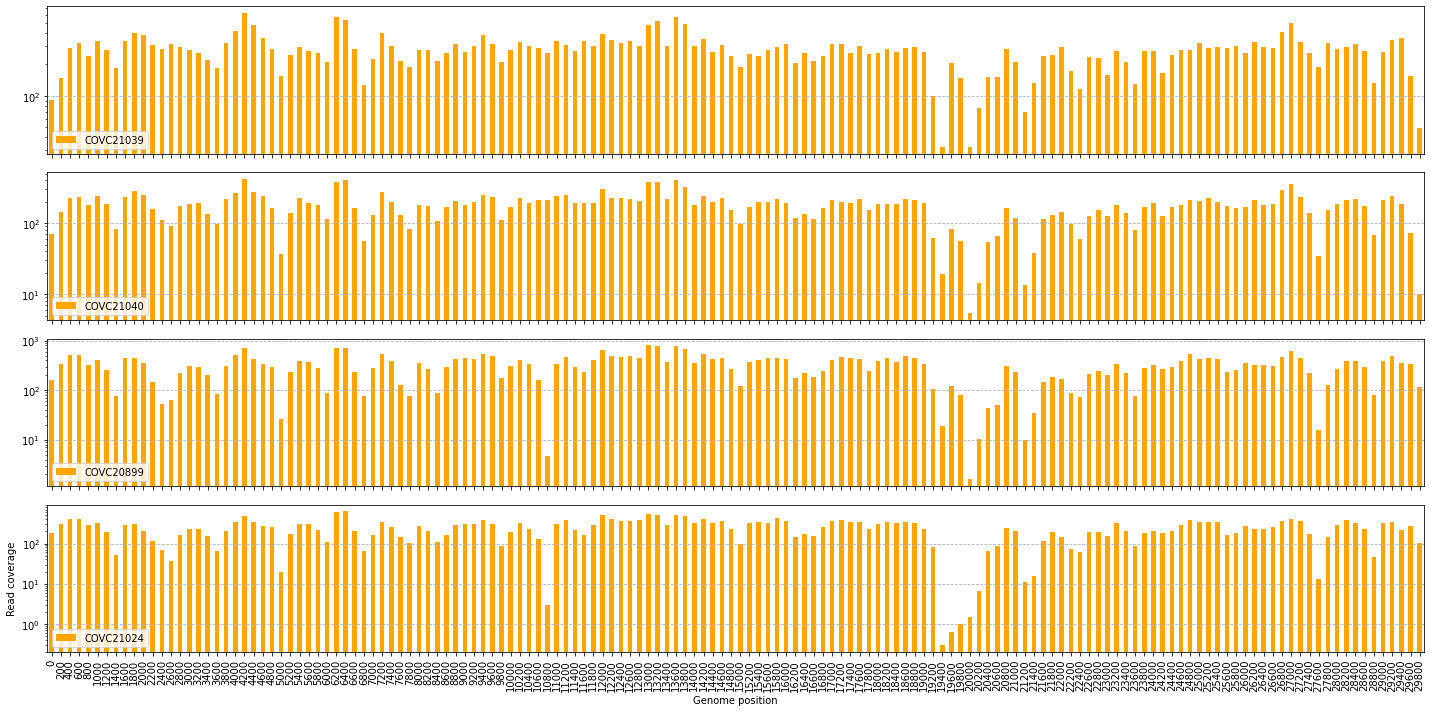

In [211]:
# plot read depths-GK
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt

suffix = '.genome.regions.coverage.tsv'
base_dir = '/home/douso/Kibet/2021-04-30_run6_NPHL_COVC/dpt/b1.530'
files = ['COVC21039_S17.trim.mkD.genome.regions.coverage.tsv',
 'COVC21040_S18.trim.mkD.genome.regions.coverage.tsv',
 'COVC20899_S2.trim.mkD.genome.regions.coverage.tsv',
 'COVC21024_S11.trim.mkD.genome.regions.coverage.tsv']
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fig, axs = plt.subplots(a, b, figsize=(20, 10))

xtick = range(0, 30000, 500)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    try:
        df1 = pd.read_table(f'{base_dir}/{file}')
        d = df1['coverage'].to_frame()
        d.set_index(np.arange(0, 30000, 200)).plot.bar(logy=True, ax=axs[c], sharex=True, color='orange')
        axs[c].legend([sample_name], loc='lower left')
        axs[c].grid(axis='y', ls='--')
        text = file.split('_')[1]
        plt.ylabel('Read coverage')
    except TypeError:
            print(f'no numeric data to plot for {file}')
    finally: pass
plt.xlabel('Genome position')
# plt.xticks(xtick, rotation=45)
plt.tight_layout()
# plt.grid()
plt.show()
# fig.savefig('/home/douso/Kibet/2021-04-30_run6_NPHL_COVC/dpt/b1.530/bar-genome-b1.530.pdf')